# REAL ESTATE PRICE PREDICTION PIPELINE

- This script implements a complete machine learning pipeline for predicting
- real estate prices per square meter, with proper handling of data leakage
- through correct target encoding methodology.


# 1. Data Loading & Initial Exploration

In [1]:

import pandas as pd
import numpy as np
import re
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import LabelEncoder
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import pearsonr, spearmanr
import warnings
warnings.filterwarnings('ignore')




In [2]:
df = pd.read_csv("case_data.csv")
df

,District,Address,Class,HouseNumber,Building,Plot,FloorsTotal,HandoverDate,Phase,BuildingType,...,LivingArea,KitchenArea,HallwayArea,BathroomArea,BalconyArea,PlotArea,PricePerMeter,TotalCost,Developer_encoded,Complex_encoded
0,МО Ленинский г.о.,"Сапроново д., Калиновая ул.",Комфорт,NaN,1,NaN,25,Сдан,1,Монолит,...,43.7,12.2,13.5,"3,4с+1,3т","3,4л",0.0,266300.0,20265430.0,Developer58,Complex0
1,МО Ленинский г.о.,"Сапроново д., Калиновая ул.",Комфорт,NaN,1,NaN,25,Сдан,1,Монолит,...,25.1,25.4,10.2,"3,4с+2т",3л,0.0,270900.0,19017180.0,Developer58,Complex0
2,МО Ленинский г.о.,"Сапроново д., Калиновая ул.",Комфорт,NaN,1,NaN,25,Сдан,1,Монолит,...,43.9,13.4,13.6,"3,5с+1,4т","4,3б",0.0,264900.0,20635710.0,Developer58,Complex0
3,МО Ленинский г.о.,"Сапроново д., Калиновая ул.",Комфорт,NaN,1,NaN,25,Сдан,1,Монолит,...,43.7,12.2,13.5,"3,4с+1,3т","3,4л",0.0,267300.0,20341530.0,Developer58,Complex0
4,МО Ленинский г.о.,"Сапроново д., Калиновая ул.",Комфорт,NaN,1,NaN,25,Сдан,1,Монолит,...,43.9,13.4,13.6,"3,5с+1,4т","4,3б",0.0,266400.0,20752560.0,Developer58,Complex0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59305,МО Мытищи г.о.,"Мытищи г., Колонцова ул.",Комфорт,NaN,14,NaN,24,2028 г. 2 кв.,4,Монолит,...,0.0,0.0,0.0,0,0,0.0,347900.0,7236320.0,Developer76,Complex404
59306,МО Мытищи г.о.,"Мытищи г., Колонцова ул.",Комфорт,NaN,14,NaN,24,2028 г. 2 кв.,4,Монолит,...,0.0,0.0,0.0,0,0,0.0,346200.0,7235580.0,Developer76,Complex404
59307,МО Мытищи г.о.,"Мытищи г., Колонцова ул.",Комфорт,NaN,14,NaN,24,2028 г. 2 кв.,4,Монолит,...,0.0,0.0,0.0,0,0,0.0,345200.0,7214680.0,Developer76,Complex404
59308,МО Мытищи г.о.,"Мытищи г., Колонцова ул.",Комфорт,NaN,14,NaN,24,2028 г. 2 кв.,4,Монолит,...,0.0,0.0,0.0,0,0,0.0,356200.0,7052760.0,Developer76,Complex404


**Explanation:**
- Load the CSV file containing real estate data
- Initial dataset: **59,310 rows × 40 columns**

**Dataset Structure:**
```
Columns include:
- District, Address, Class, HouseNumber, Building
- FloorsTotal, Floor, HandoverDate, Phase
- TotalArea, LivingArea, KitchenArea, etc.
- PricePerMeter (TARGET VARIABLE)
- Developer_encoded, Complex_encoded

In [3]:
df = df[df['PricePerMeter'] > 0].copy()
print(f"After removing zero prices: {df.shape}")

After removing zero prices: (59306, 40)


Why this step:

- Remove data quality issues where price = 0 (likely data entry errors)
- Removed 4 rows with zero prices
- Final dataset: 59,306 rows

# 2. Data Quality Analysis

In [4]:
print(f"Price per meter stats:\n{df['PricePerMeter'].describe()}")


Price per meter stats:
count    5.930600e+04
mean     5.075143e+05
std      3.874089e+05
min      8.229200e+04
25%      2.993850e+05
50%      4.314250e+05
75%      5.956000e+05
max      1.055073e+07
Name: PricePerMeter, dtype: float64


**Key Observations:**

- Large standard deviation (387K) relative to mean (507K) → high variability
- Max value (10.5M) is 20x the mean → extreme outliers present
- Median < Mean → right-skewed distribution (expensive outliers pulling mean up)

**Why this matters:**

- Extreme outliers can distort model training
- Need robust outlier handling strategy
- Understanding distribution helps choose appropriate transformations

# 3. Data Visualization

This script performs thorough exploratory data analysis (EDA) BEFORE any
feature engineering, providing insights into raw data patterns, distributions,
relationships, and quality issues.

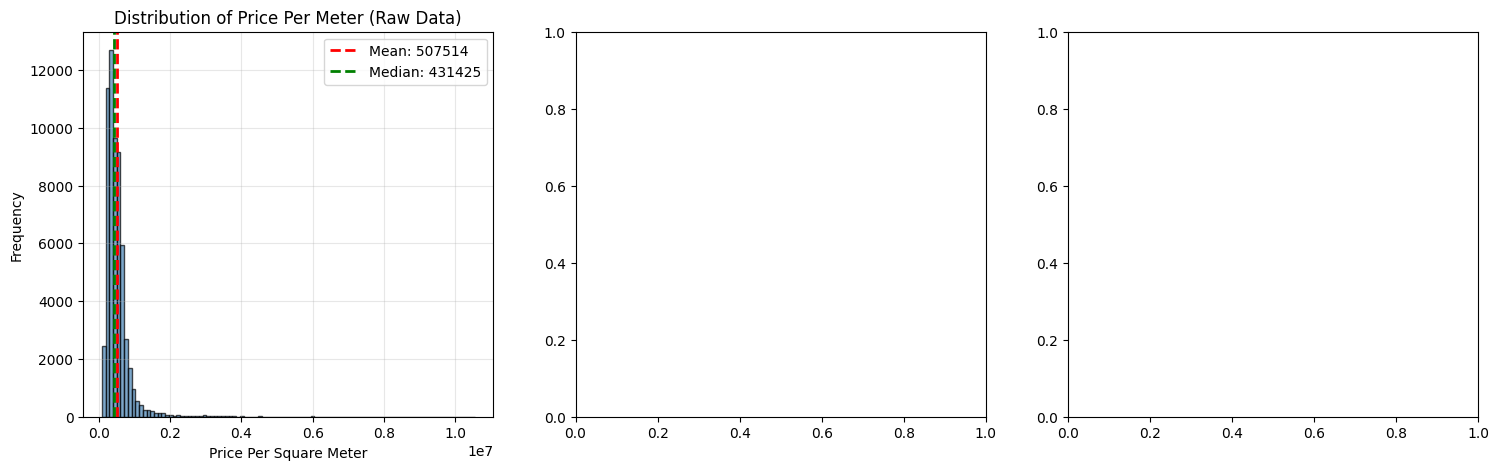

In [5]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Histogram
axes[0].hist(df['PricePerMeter'], bins=100, edgecolor='black', alpha=0.7, color='steelblue')
axes[0].set_xlabel('Price Per Square Meter')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Distribution of Price Per Meter (Raw Data)')
axes[0].axvline(df['PricePerMeter'].mean(), color='red', linestyle='--', linewidth=2, label=f'Mean: {df["PricePerMeter"].mean():.0f}')
axes[0].axvline(df['PricePerMeter'].median(), color='green', linestyle='--', linewidth=2, label=f'Median: {df["PricePerMeter"].median():.0f}')
axes[0].legend()
axes[0].grid(alpha=0.3)

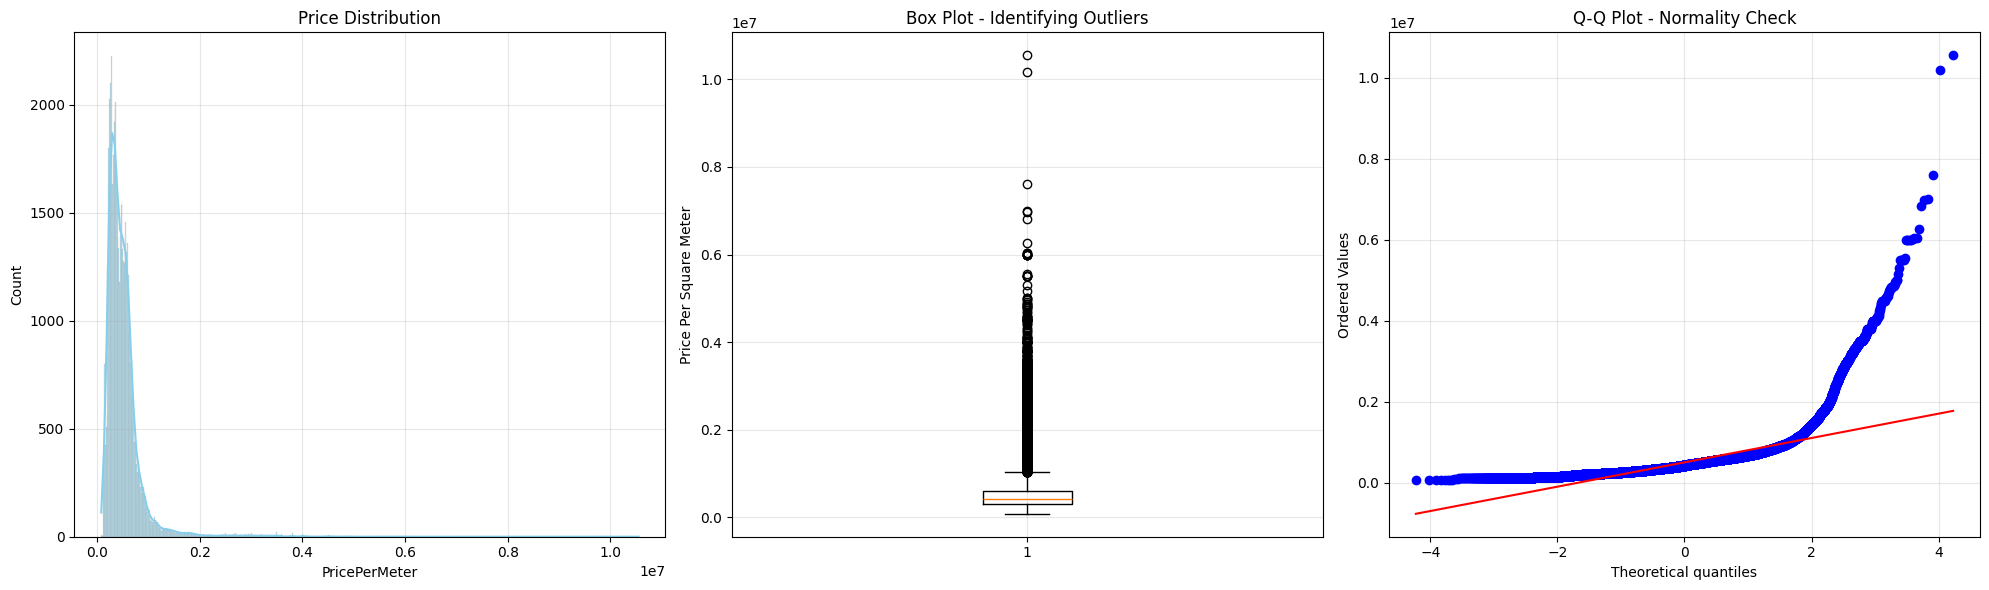

In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats

fig, axes = plt.subplots(1, 3, figsize=(20, 6))

# Histogram (Standard distribution view)
sns.histplot(df['PricePerMeter'], kde=True, ax=axes[0], color='skyblue')
axes[0].set_title('Price Distribution')
axes[0].grid(alpha=0.3)

# Box Plot
# This identifies the "whiskers" and the dots (outliers)
axes[1].boxplot(df['PricePerMeter'], vert=True)
axes[1].set_ylabel('Price Per Square Meter')
axes[1].set_title('Box Plot - Identifying Outliers')
axes[1].grid(alpha=0.3)

# Q-Q Plot
stats.probplot(df['PricePerMeter'], dist="norm", plot=axes[2])
axes[2].set_title('Q-Q Plot - Normality Check')
axes[2].grid(alpha=0.3)

plt.tight_layout()

plt.show()



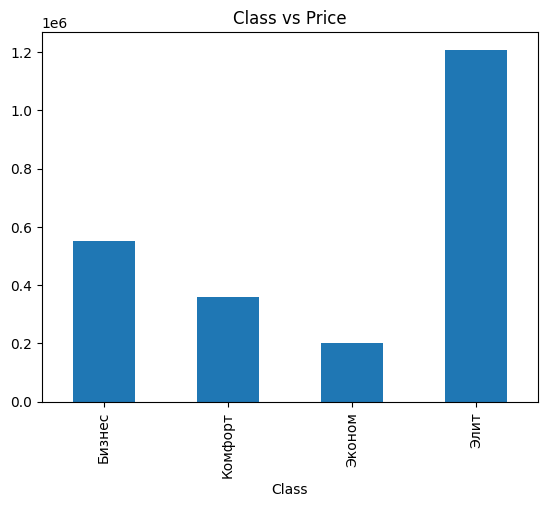

In [7]:
df.groupby('Class')['PricePerMeter'].mean().plot(kind='bar')
plt.title("Class vs Price")
plt.show()


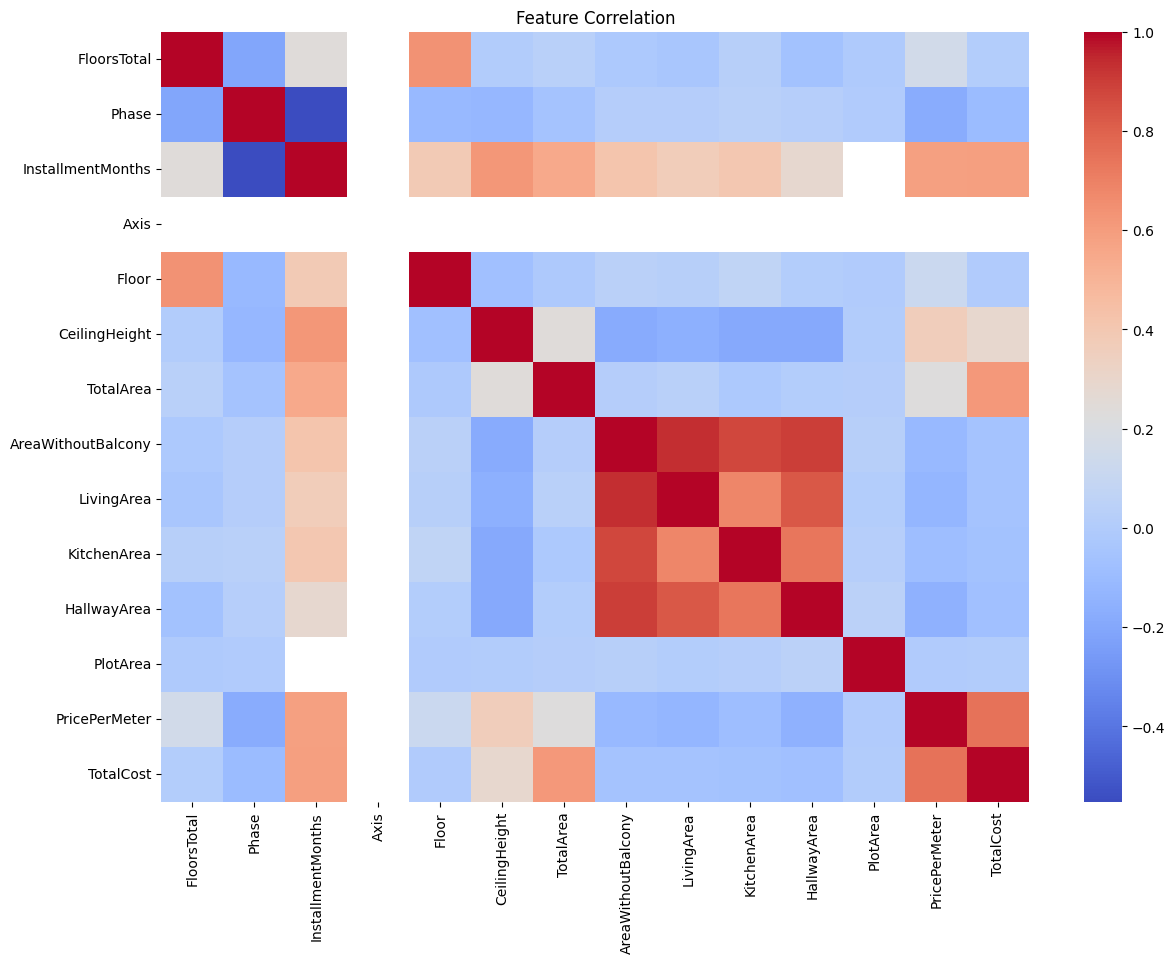

In [8]:
import seaborn as sns

plt.figure(figsize=(14,10))
sns.heatmap(df.corr(numeric_only=True), cmap='coolwarm')
plt.title("Feature Correlation")
plt.show()


In [9]:

print(f"Mean Price/m²: {df['PricePerMeter'].mean():.2f}")
print(f"Median Price/m²: {df['PricePerMeter'].median():.2f}")
print(f"Std Dev: {df['PricePerMeter'].std():.2f}")
print(f"Skewness: {df['PricePerMeter'].skew():.2f}")

Mean Price/m²: 507514.27
Median Price/m²: 431425.00
Std Dev: 387408.86
Skewness: 5.59


# 3. Outlier Detection & Handling

**Purpose:** Remove or cap extreme outliers that could skew our model's predictions.

**Methodology:**
- Using IQR (Interquartile Range) method for robust outlier detection
- IQR = Q3 - Q1 (the middle 50% of data)
- Upper bound = Q3 + 3×IQR (generous threshold to preserve legitimate high prices)
- We cap at the minimum of (upper_bound, 99.5th percentile) to be conservative

**Why 3×IQR instead of 1.5×IQR?**
- Real estate prices naturally have high variance
- Luxury properties legitimately cost much more
- 3×IQR captures true high-end market while removing data errors

**Features being capped:**
- PricePerMeter: Main target variable
- TotalArea: Extremely large properties might be data errors
- CeilingHeight: Heights >5.5m are unusual for residential properties. Outlier Detection & Handling

In [10]:
Q1 = df['PricePerMeter'].quantile(0.25)
Q3 = df['PricePerMeter'].quantile(0.75)
IQR = Q3 - Q1
upper_bound = Q3 + 3 * IQR
ppm_cap = min(upper_bound, df['PricePerMeter'].quantile(0.995))

print(f"\nPricePerMeter outlier statistics:")
print(f"  Q1 (25th percentile): {Q1:.2f}")
print(f"  Q3 (75th percentile): {Q3:.2f}")
print(f"  IQR: {IQR:.2f}")
print(f"  Upper bound (Q3 + 3×IQR): {upper_bound:.2f}")
print(f"  99.5th percentile: {df['PricePerMeter'].quantile(0.995):.2f}")
print(f"  Final cap value: {ppm_cap:.2f}")
original_ppm = df['PricePerMeter'].copy()
original_area = df['TotalArea'].copy()
original_ceiling = df['CeilingHeight'].copy()

# Apply caps
df['PricePerMeter'] = df['PricePerMeter'].clip(upper=ppm_cap)
df['TotalArea'] = df['TotalArea'].clip(upper=df['TotalArea'].quantile(0.99))
df['CeilingHeight'] = df['CeilingHeight'].clip(upper=5.5)

# Count affected records
ppm_capped = (original_ppm != df['PricePerMeter']).sum()
area_capped = (original_area != df['TotalArea']).sum()
ceiling_capped = (original_ceiling != df['CeilingHeight']).sum()

print(f"\nRecords affected by capping:")
print(f"  PricePerMeter: {ppm_capped} ({ppm_capped/len(df)*100:.2f}%)")
print(f"  TotalArea: {area_capped} ({area_capped/len(df)*100:.2f}%)")
print(f"  CeilingHeight: {ceiling_capped} ({ceiling_capped/len(df)*100:.2f}%)")


PricePerMeter outlier statistics:
  Q1 (25th percentile): 299385.00
  Q3 (75th percentile): 595600.00
  IQR: 296215.00
  Upper bound (Q3 + 3×IQR): 1484245.00
  99.5th percentile: 3001006.36
  Final cap value: 1484245.00

Records affected by capping:
  PricePerMeter: 1236 (2.08%)
  TotalArea: 594 (1.00%)
  CeilingHeight: 215 (0.36%)


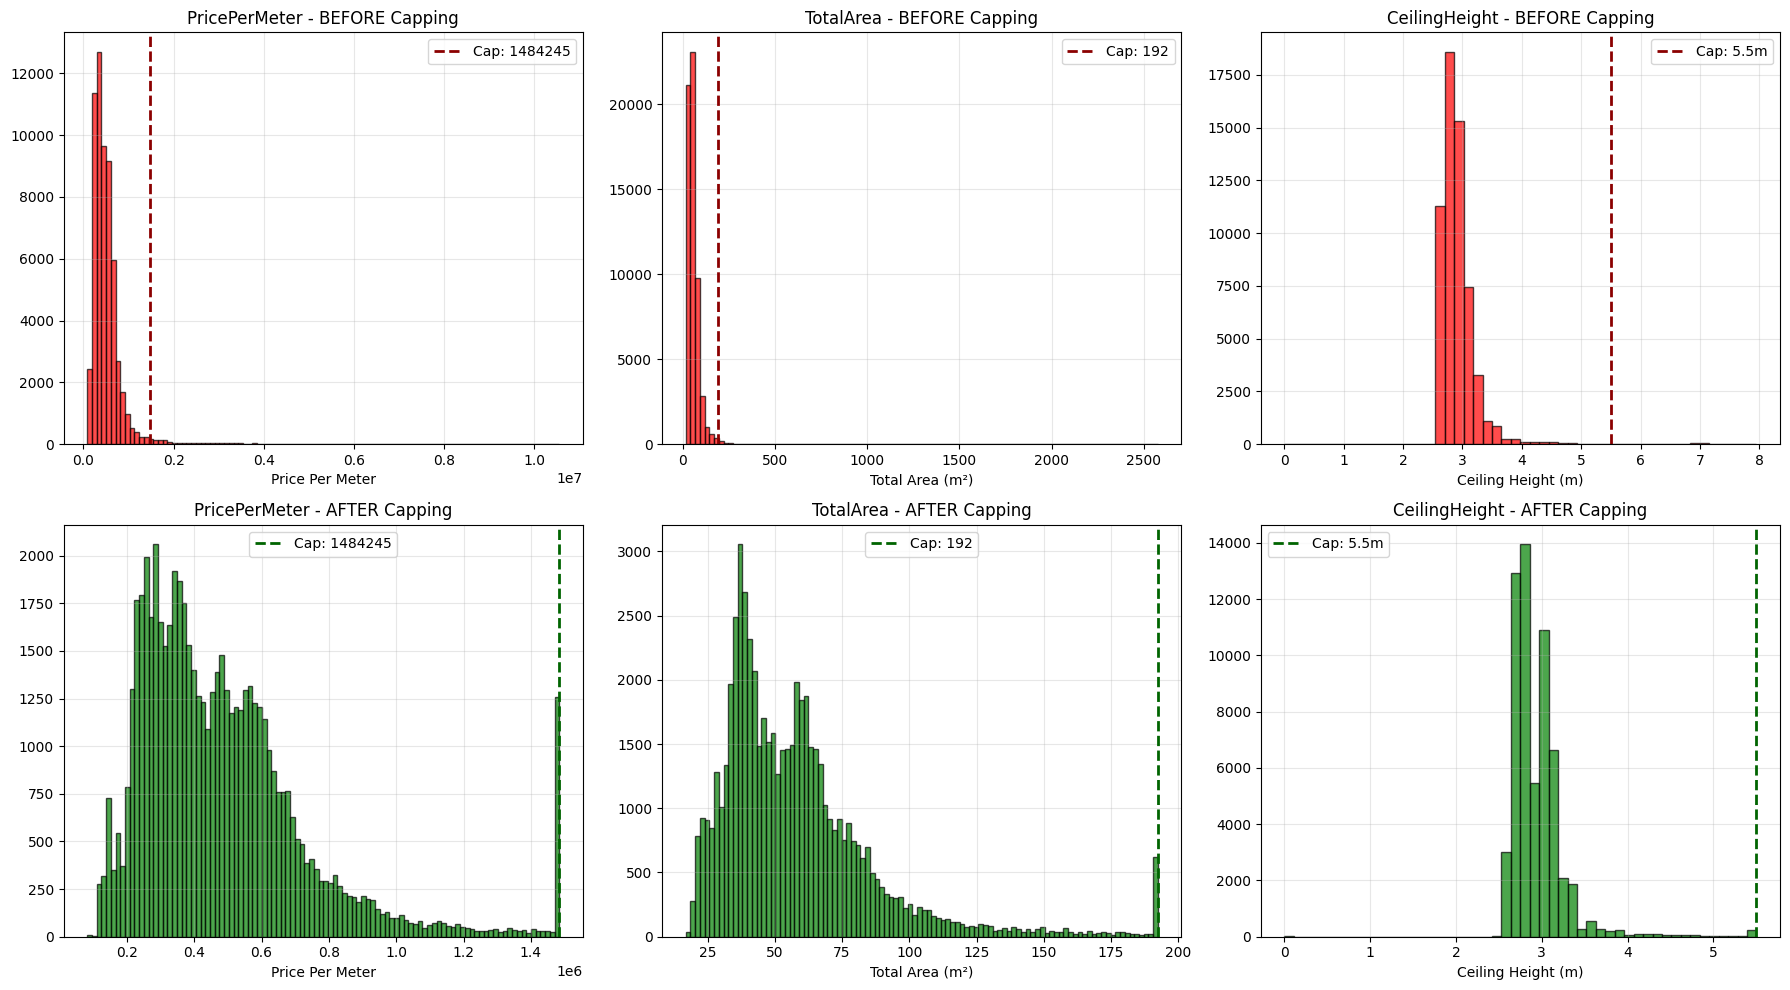

In [11]:
# Visualization 2: Before/After Outlier Handling
fig, axes = plt.subplots(2, 3, figsize=(18, 10))

# PricePerMeter
axes[0, 0].hist(original_ppm, bins=100, alpha=0.7, color='red', edgecolor='black')
axes[0, 0].axvline(ppm_cap, color='darkred', linestyle='--', linewidth=2, label=f'Cap: {ppm_cap:.0f}')
axes[0, 0].set_title('PricePerMeter - BEFORE Capping')
axes[0, 0].set_xlabel('Price Per Meter')
axes[0, 0].legend()
axes[0, 0].grid(alpha=0.3)

axes[1, 0].hist(df['PricePerMeter'], bins=100, alpha=0.7, color='green', edgecolor='black')
axes[1, 0].axvline(ppm_cap, color='darkgreen', linestyle='--', linewidth=2, label=f'Cap: {ppm_cap:.0f}')
axes[1, 0].set_title('PricePerMeter - AFTER Capping')
axes[1, 0].set_xlabel('Price Per Meter')
axes[1, 0].legend()
axes[1, 0].grid(alpha=0.3)

# TotalArea
area_cap = df['TotalArea'].quantile(0.99)
axes[0, 1].hist(original_area, bins=100, alpha=0.7, color='red', edgecolor='black')
axes[0, 1].axvline(area_cap, color='darkred', linestyle='--', linewidth=2, label=f'Cap: {area_cap:.0f}')
axes[0, 1].set_title('TotalArea - BEFORE Capping')
axes[0, 1].set_xlabel('Total Area (m²)')
axes[0, 1].legend()
axes[0, 1].grid(alpha=0.3)

axes[1, 1].hist(df['TotalArea'], bins=100, alpha=0.7, color='green', edgecolor='black')
axes[1, 1].axvline(area_cap, color='darkgreen', linestyle='--', linewidth=2, label=f'Cap: {area_cap:.0f}')
axes[1, 1].set_title('TotalArea - AFTER Capping')
axes[1, 1].set_xlabel('Total Area (m²)')
axes[1, 1].legend()
axes[1, 1].grid(alpha=0.3)

# CeilingHeight
axes[0, 2].hist(original_ceiling.dropna(), bins=50, alpha=0.7, color='red', edgecolor='black')
axes[0, 2].axvline(5.5, color='darkred', linestyle='--', linewidth=2, label='Cap: 5.5m')
axes[0, 2].set_title('CeilingHeight - BEFORE Capping')
axes[0, 2].set_xlabel('Ceiling Height (m)')
axes[0, 2].legend()
axes[0, 2].grid(alpha=0.3)

axes[1, 2].hist(df['CeilingHeight'].dropna(), bins=50, alpha=0.7, color='green', edgecolor='black')
axes[1, 2].axvline(5.5, color='darkgreen', linestyle='--', linewidth=2, label='Cap: 5.5m')
axes[1, 2].set_title('CeilingHeight - AFTER Capping')
axes[1, 2].set_xlabel('Ceiling Height (m)')
axes[1, 2].legend()
axes[1, 2].grid(alpha=0.3)
plt.tight_layout()
# plt.savefig('/mnt/user-data/outputs/02_outlier_handling.png', dpi=300, bbox_inches='tight')
plt.show()

# 4. Feature Engineering (Non-Target Features)

**Purpose:** Create new features from existing data to help the model learn patterns.

**Feature Categories Created:**
### 4.1 Area Features
- **BalconyArea_Sum**: Total balcony area (parsed from string format)
- **BathroomArea_Sum**: Total bathroom area (parsed from string format)
- **Living_to_Total**: Ratio of living space to total area (efficiency metric)
- **Kitchen_to_Total**: Kitchen size relative to apartment size
- **Space_Efficiency**: (Living + Kitchen) / Total area (higher = better layout)

In [12]:
# Parse areas
def parse_area_str(val):
    """Parse area strings that may contain multiple values or special formats"""
    if pd.isna(val) or val == '0.0' or val == 0:
        return 0.0
    nums = re.findall(r"[-+]?\d*\.\d+|\d+", str(val).replace(',', '.'))
    return sum([float(n) for n in nums])

df['BalconyArea_Sum'] = df['BalconyArea'].apply(parse_area_str)
df['BathroomArea_Sum'] = df['BathroomArea'].apply(parse_area_str)

### 4.2 Temporal Features
- **YearsToWait**: Years until building handover (0 = already completed)
- **Is_Ready**: Binary flag for completed buildings (immediate move-in)
- **Construction_Status**: Categorical grouping of construction timeline

In [13]:
def get_years_to_handover(val):
    """Extract years until building completion from HandoverDate"""
    if str(val) == 'Сдан':
        return 0
    years = re.findall(r'\d{4}', str(val))
    return (int(years[0]) - 2024) if years else 1

df['YearsToWait'] = df['HandoverDate'].apply(get_years_to_handover)

### 4.3 Location Features
- **Is_Oblast**: Binary flag for Moscow Oblast (suburban) vs Moscow city
  - Properties in Moscow Oblast typically cost less per m²

In [14]:
# Geographical
df['Is_Oblast'] = df['District'].str.startswith('МО', na=False).astype(int)

### 4.4 Floor Features
- **Is_First_Floor**: Ground floor apartments (often less desirable)
- **Is_Top_Floor**: Penthouse level (premium or problematic)
- **Floor_Position**: Normalized floor position (0 to 1)
- **Is_Middle_Floor**: Middle floors (typically most desirable)
- **Floor_Group**: Binned floor ranges (Low: 1-3, Mid: 4-7, High: 8-15, Very High: 16+)

In [15]:
# Floor features
df['Is_First_Floor'] = (df['Floor'] <= 1).astype(int)
df['Is_Top_Floor'] = (df['Floor'] == df['FloorsTotal']).astype(int)
df['Floor_Position'] = df['Floor'] / df['FloorsTotal'].replace(0, 1)
df['Is_Middle_Floor'] = ((df['Floor'] > 1) & (df['Floor'] < df['FloorsTotal'])).astype(int)
floor_values = df['Floor'].fillna(1).values
df['Floor_Group'] = np.digitize(floor_values, bins=[0, 3, 7, 15, 100]) - 1

### 4.5 Property Type Features
- **Is_Euro**: European-style layout (open plan, modern)
- **Is_Studio**: Studio apartment
- **Rooms**: Number of rooms (extracted from PropertyType)
- **Area_Per_Room**: Average room size

In [16]:
# Property type
df['Is_Euro'] = df['PropertyType'].str.contains('Евро', na=False).astype(int)
df['Is_Studio'] = df['PropertyType'].str.contains('Студия', na=False).astype(int)

def get_rooms(val):
    """Extract number of rooms from PropertyType string"""
    if 'Студия' in str(val):
        return 1
    num = re.findall(r'\d+', str(val))
    return int(num[0]) if num else 1

df['Rooms'] = df['PropertyType'].apply(get_rooms)

In [17]:
# Area ratios
df['LivingArea'] = df['LivingArea'].fillna(df['TotalArea'] * 0.6)
df['KitchenArea'] = df['KitchenArea'].fillna(df['TotalArea'] * 0.15)
df['AreaWithoutBalcony'] = df['AreaWithoutBalcony'].fillna(df['TotalArea'])
df['Living_to_Total'] = df['LivingArea'] / df['TotalArea'].replace(0, 1)
df['Kitchen_to_Total'] = df['KitchenArea'] / df['TotalArea'].replace(0, 1)
df['Balcony_to_Total'] = df['BalconyArea_Sum'] / df['TotalArea'].replace(0, 1)
df['Bathroom_to_Total'] = df['BathroomArea_Sum'] / df['TotalArea'].replace(0, 1)
df['Space_Efficiency'] = (df['LivingArea'] + df['KitchenArea']) / df['TotalArea'].replace(0, 1)
df['Area_Per_Room'] = df['TotalArea'] / df['Rooms'].replace(0, 1)

### 4.6 Quality & Amenities
- **Quality_Score**: Ordinal encoding of Class (0=Economy, 4=Elite)
- **Has_Finishing**: Whether apartment comes with finishing
- **Has_Mortgage**: Mortgage availability
- **Has_Subsidies**: Government subsidies available

In [18]:
# Quality
class_map = {'Эконом': 0, 'Комфорт': 1, 'Бизнес': 2, 'Премиум': 3, 'Элитный': 4}
df['Quality_Score'] = df['Class'].map(class_map).fillna(0)
df['Has_Finishing'] = (df['Finishing'] != 'Без отделки').astype(int)
df['Has_Mortgage'] = (df['Mortgage'] == 'Да').astype(int)
df['Has_Subsidies'] = (df['Subsidies'] == 'Да').astype(int)


In [19]:
# Building
floors_values = df['FloorsTotal'].fillna(5).values
df['Building_Height_Group'] = np.digitize(floors_values, bins=[0, 5, 10, 17, 100]) - 1

### 3.7 Polynomial & Interaction Features
- **TotalArea_Squared**: Captures non-linear price-area relationship
- **TotalArea_Log**: Reduces impact of extreme areas
- **Rooms_x_Area**: Interaction between room count and size
- **Quality_x_Area**: Premium spaces command higher prices
- **Floor_x_FloorsTotal**: Captures floor position in building context

In [20]:
df['TotalArea_Squared'] = df['TotalArea'] ** 2
df['Floor_Squared'] = df['Floor'] ** 2
df['TotalArea_Log'] = np.log1p(df['TotalArea'])
df['CeilingHeight_Squared'] = df['CeilingHeight'] ** 2

In [21]:
# Interactions
df['Rooms_x_Area'] = df['Rooms'] * df['TotalArea']
df['Quality_x_Area'] = df['Quality_Score'] * df['TotalArea']
df['Floor_x_FloorsTotal'] = df['Floor'] * df['FloorsTotal']

**Why these features?**
- Real estate prices are driven by complex interactions
- Location + Quality + Size work together, not independently
- Polynomial features capture diminishing returns (e.g., 100m² → 200m² price increase differs from 50m² → 100m²)
"""

In [22]:
# Label encode categoricals
cat_cols = ['District', 'Class', 'Phase', 'BuildingType', 'PropertyCategory',
            'Apartments', 'Finishing', 'ApartmentOption', 'Mortgage',
            'Subsidies', 'Layout', 'Developer_encoded', 'Complex_encoded', 'Section']

for col in cat_cols:
    if col in df.columns:
        le = LabelEncoder()
        df[col + '_encoded'] = le.fit_transform(df[col].fillna('Unknown').astype(str))

print(f"Features created: {df.shape[1]} total columns")

Features created: 84 total columns


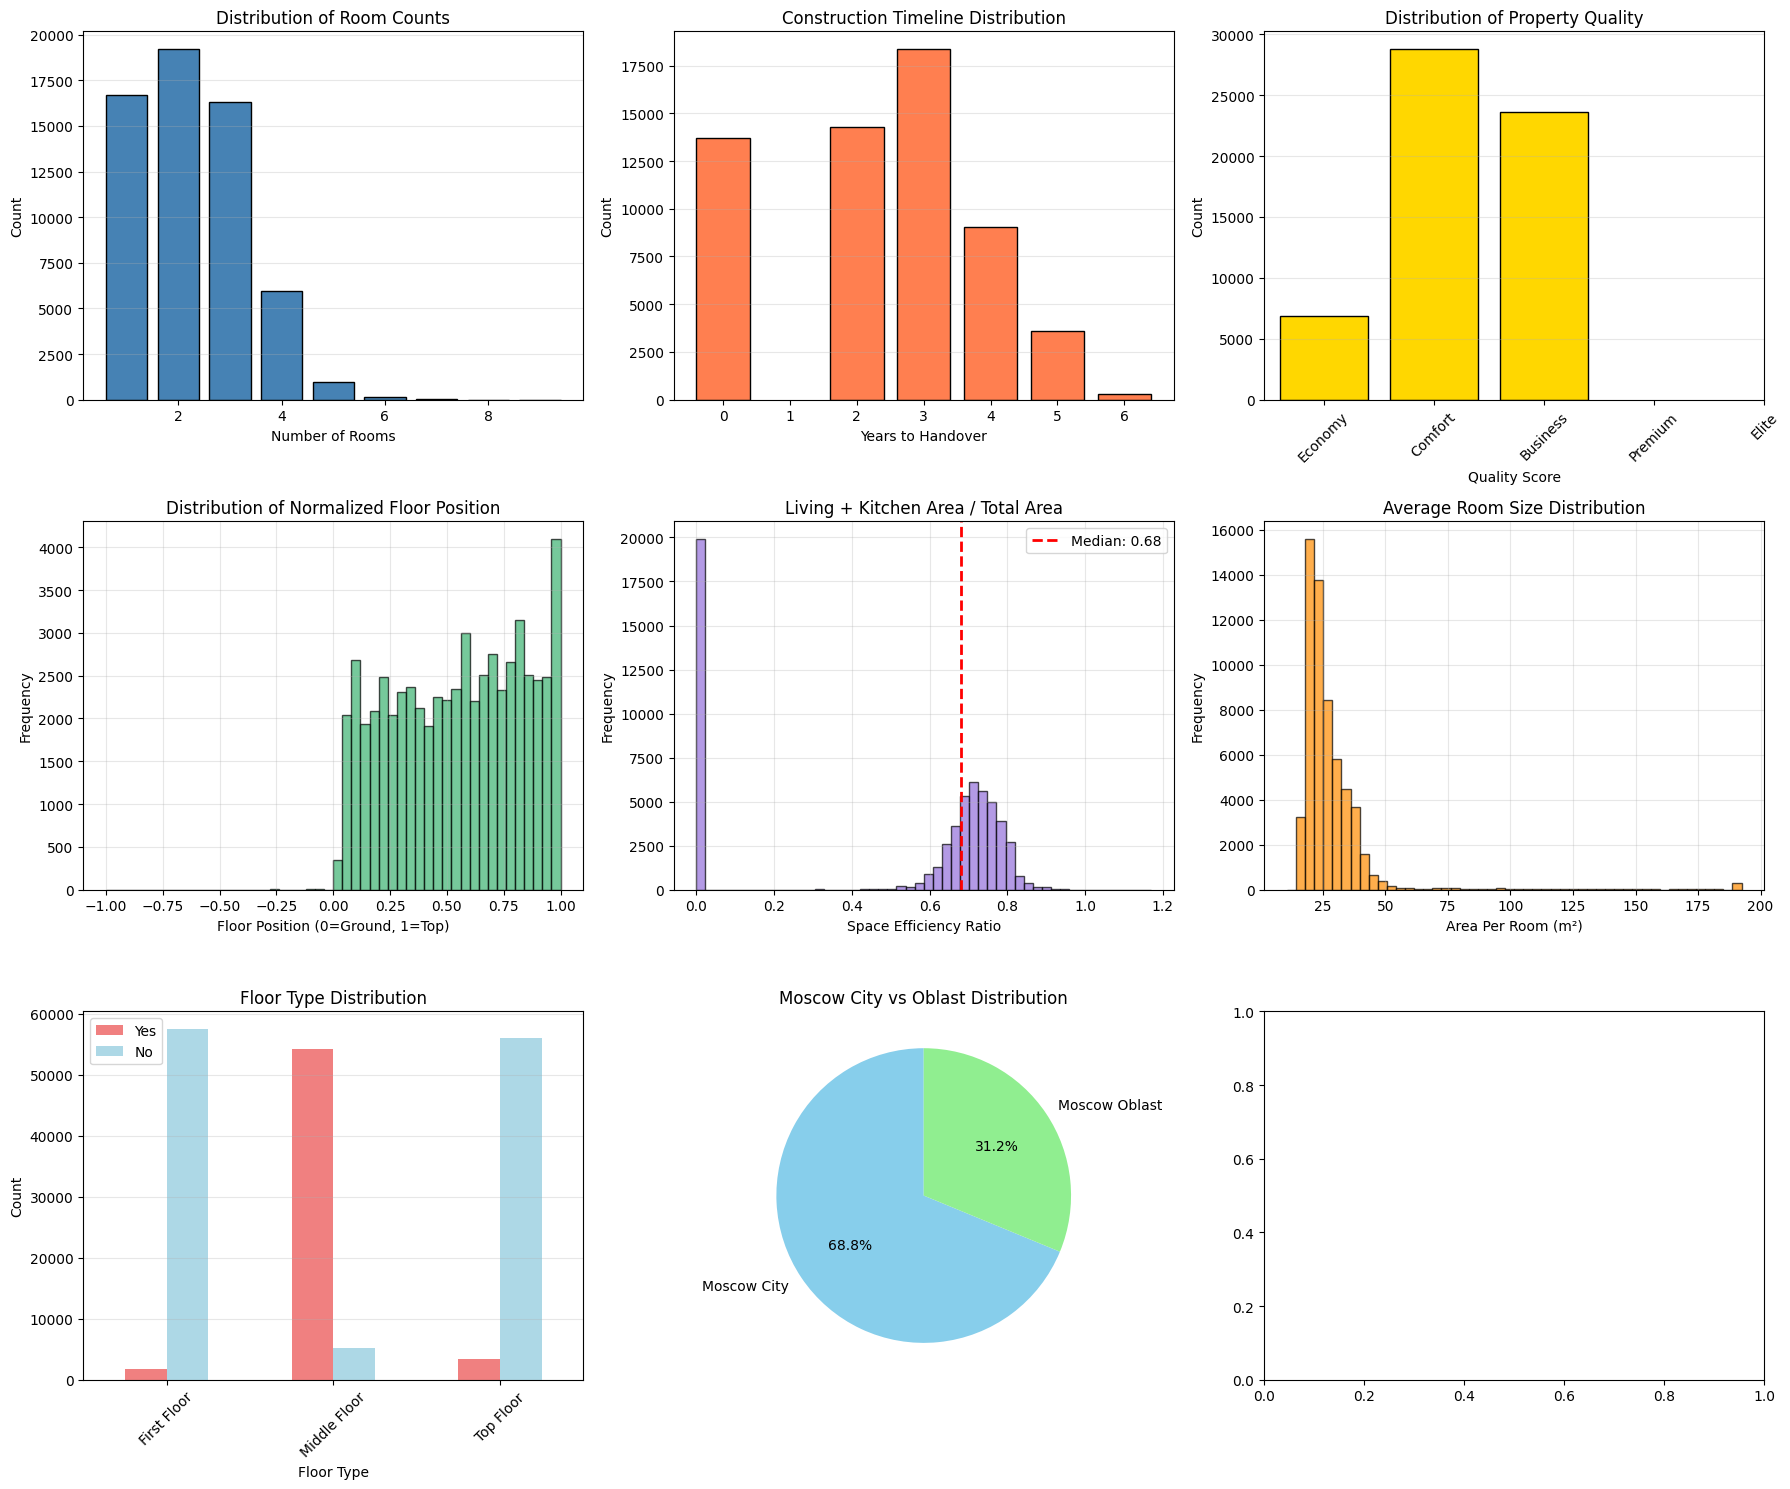

In [23]:
# Visualization 3: Key Feature Distributions
fig, axes = plt.subplots(3, 3, figsize=(18, 15))

# Room distribution
room_counts = df['Rooms'].value_counts().sort_index()
axes[0, 0].bar(room_counts.index, room_counts.values, color='steelblue', edgecolor='black')
axes[0, 0].set_xlabel('Number of Rooms')
axes[0, 0].set_ylabel('Count')
axes[0, 0].set_title('Distribution of Room Counts')
axes[0, 0].grid(alpha=0.3, axis='y')

# Years to wait
wait_counts = df['YearsToWait'].value_counts().sort_index()
axes[0, 1].bar(wait_counts.index, wait_counts.values, color='coral', edgecolor='black')
axes[0, 1].set_xlabel('Years to Handover')
axes[0, 1].set_ylabel('Count')
axes[0, 1].set_title('Construction Timeline Distribution')
axes[0, 1].grid(alpha=0.3, axis='y')

# Quality score
quality_counts = df['Quality_Score'].value_counts().sort_index()
quality_labels = ['Economy', 'Comfort', 'Business', 'Premium', 'Elite']
axes[0, 2].bar(quality_counts.index, quality_counts.values, color='gold', edgecolor='black')
axes[0, 2].set_xlabel('Quality Score')
axes[0, 2].set_ylabel('Count')
axes[0, 2].set_title('Distribution of Property Quality')
axes[0, 2].set_xticks(range(5))
axes[0, 2].set_xticklabels(quality_labels, rotation=45)
axes[0, 2].grid(alpha=0.3, axis='y')

# Floor position
axes[1, 0].hist(df['Floor_Position'].dropna(), bins=50, color='mediumseagreen', edgecolor='black', alpha=0.7)
axes[1, 0].set_xlabel('Floor Position (0=Ground, 1=Top)')
axes[1, 0].set_ylabel('Frequency')
axes[1, 0].set_title('Distribution of Normalized Floor Position')
axes[1, 0].grid(alpha=0.3)

# Space efficiency
axes[1, 1].hist(df['Space_Efficiency'].dropna(), bins=50, color='mediumpurple', edgecolor='black', alpha=0.7)
axes[1, 1].set_xlabel('Space Efficiency Ratio')
axes[1, 1].set_ylabel('Frequency')
axes[1, 1].set_title('Living + Kitchen Area / Total Area')
axes[1, 1].axvline(df['Space_Efficiency'].median(), color='red', linestyle='--', linewidth=2, label=f'Median: {df["Space_Efficiency"].median():.2f}')
axes[1, 1].legend()
axes[1, 1].grid(alpha=0.3)

# Area per room
axes[1, 2].hist(df['Area_Per_Room'].dropna(), bins=50, color='darkorange', edgecolor='black', alpha=0.7)
axes[1, 2].set_xlabel('Area Per Room (m²)')
axes[1, 2].set_ylabel('Frequency')
axes[1, 2].set_title('Average Room Size Distribution')
axes[1, 2].grid(alpha=0.3)
floor_types = pd.DataFrame({
    'First Floor': [df['Is_First_Floor'].sum(), len(df) - df['Is_First_Floor'].sum()],
    'Middle Floor': [df['Is_Middle_Floor'].sum(), len(df) - df['Is_Middle_Floor'].sum()],
    'Top Floor': [df['Is_Top_Floor'].sum(), len(df) - df['Is_Top_Floor'].sum()]
}, index=['Yes', 'No'])
floor_types.T.plot(kind='bar', stacked=False, ax=axes[2, 0], color=['lightcoral', 'lightblue'])
axes[2, 0].set_xlabel('Floor Type')
axes[2, 0].set_ylabel('Count')
axes[2, 0].set_title('Floor Type Distribution')
axes[2, 0].legend(['Yes', 'No'])
axes[2, 0].grid(alpha=0.3, axis='y')
axes[2, 0].tick_params(axis='x', rotation=45)

# Oblast vs Moscow
location_counts = df['Is_Oblast'].value_counts()
axes[2, 1].pie(location_counts.values, labels=['Moscow City', 'Moscow Oblast'], autopct='%1.1f%%',
               colors=['skyblue', 'lightgreen'], startangle=90)
axes[2, 1].set_title('Moscow City vs Oblast Distribution')


plt.tight_layout()
plt.show()

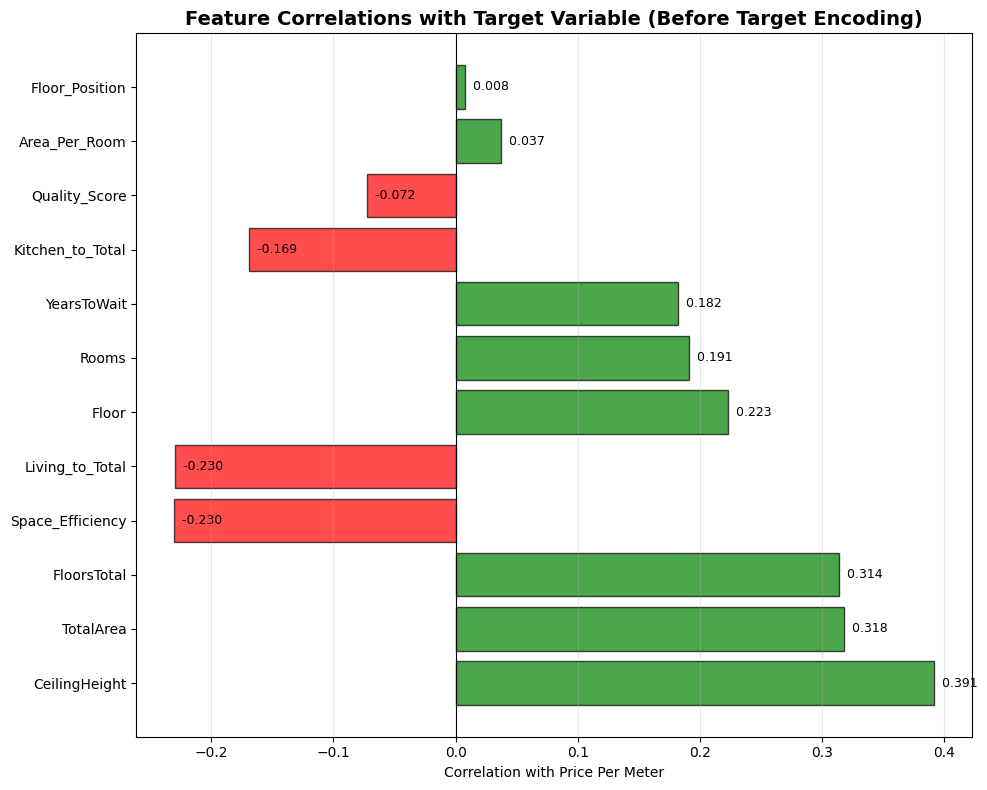


Top 5 correlated features:
  CeilingHeight: 0.391
  TotalArea: 0.318
  FloorsTotal: 0.314
  Space_Efficiency: -0.230
  Living_to_Total: -0.230


In [24]:
# Visualization 4: Feature Correlations with Target
numeric_features = ['TotalArea', 'Floor', 'FloorsTotal', 'CeilingHeight',
                   'Rooms', 'Quality_Score', 'YearsToWait', 'Floor_Position',
                   'Space_Efficiency', 'Area_Per_Room', 'Living_to_Total',
                   'Kitchen_to_Total']

correlations = []
for feat in numeric_features:
    if feat in df.columns:
        corr = df[feat].corr(df['PricePerMeter'])
        correlations.append({'Feature': feat, 'Correlation': corr})

corr_df = pd.DataFrame(correlations).sort_values('Correlation', key=abs, ascending=False)

fig, ax = plt.subplots(figsize=(10, 8))
colors = ['green' if x > 0 else 'red' for x in corr_df['Correlation']]
bars = ax.barh(corr_df['Feature'], corr_df['Correlation'], color=colors, edgecolor='black', alpha=0.7)
ax.set_xlabel('Correlation with Price Per Meter')
ax.set_title('Feature Correlations with Target Variable (Before Target Encoding)', fontsize=14, fontweight='bold')
ax.axvline(0, color='black', linewidth=0.8)
ax.grid(alpha=0.3, axis='x')

# Add value labels
for i, (feat, corr) in enumerate(zip(corr_df['Feature'], corr_df['Correlation'])):
    ax.text(corr, i, f'  {corr:.3f}', va='center', fontsize=9)

plt.tight_layout()
plt.show()
plt.close()

print(f"\nTop 5 correlated features:")
for idx, row in corr_df.head().iterrows():
    print(f"  {row['Feature']}: {row['Correlation']:.3f}")

## 5. Train-Test Split (BEFORE Target Encoding)

**CRITICAL FOR PREVENTING DATA LEAKAGE!**

**Why split BEFORE target encoding?**
- Target encoding uses the target variable to create features
- If we encode before splitting, test data statistics "leak" into training
- This creates artificially good performance that won't generalize

**The Data Leakage Problem:**
```
WRONG WAY (Leakage):
1. Calculate District mean price using ALL data
2. Split into train/test
3. Train model
→ Model has seen test set statistics! Overly optimistic results.

CORRECT WAY (No Leakage):
1. Split into train/test first
2. Calculate District mean price using ONLY training data
3. Apply those training statistics to test set
→ Model only knows training statistics. Realistic results.
```

**Stratified Splitting:**
- We use stratified sampling based on price bins
- Ensures train and test sets have similar price distributions
- Prevents all expensive/cheap properties ending up in one set
- More reliable performance estimates

**Split Ratio: 85% train / 15% test**
- Large enough test set for reliable evaluation
- Enough training data for the model to learn patterns

In [25]:
drop_cols = [
    'PricePerMeter', 'TotalCost', 'HandoverDate', 'PropertyType', 'Address',
    'HouseNumber', 'Building', 'Plot', 'Number', 'PIBNumber', 'Axis',
    'InstallmentUntil', 'InstallmentMonths', 'LayoutType', 'Status',
    'BalconyArea', 'BathroomArea', 'PlotArea',
    'District', 'Class', 'Phase', 'BuildingType', 'PropertyCategory',
    'Apartments', 'Finishing', 'ApartmentOption', 'Mortgage',
    'Subsidies', 'Layout', 'Developer_encoded', 'Complex_encoded', 'Section'
]

X = df.drop(columns=[col for col in drop_cols if col in df.columns])
y = df['PricePerMeter']

In [26]:
# Keep categorical columns for target encoding
categorical_features = ['District', 'Class', 'Developer_encoded', 'Complex_encoded']
cat_data = df[categorical_features].copy()

In [27]:
# Fill missing values
for col in X.select_dtypes(include=[np.number]).columns:
    X[col] = X[col].fillna(X[col].median())

In [28]:
# Stratified split
price_bins = pd.qcut(y, q=10, duplicates='drop')
X_train, X_test, y_train, y_test, cat_train, cat_test, idx_train, idx_test = train_test_split(
    X, y, cat_data, df.index, test_size=0.15, random_state=42, stratify=price_bins
)
print(f"\nSplit complete:")
print(f"Training set: {X_train.shape[0]} samples ({X_train.shape[0]/len(df)*100:.1f}%)")
print(f"Test set: {X_test.shape[0]} samples ({X_test.shape[0]/len(df)*100:.1f}%)")
print(f"Features: {X_train.shape[1]}")


Split complete:
Training set: 50410 samples (85.0%)
Test set: 8896 samples (15.0%)
Features: 52


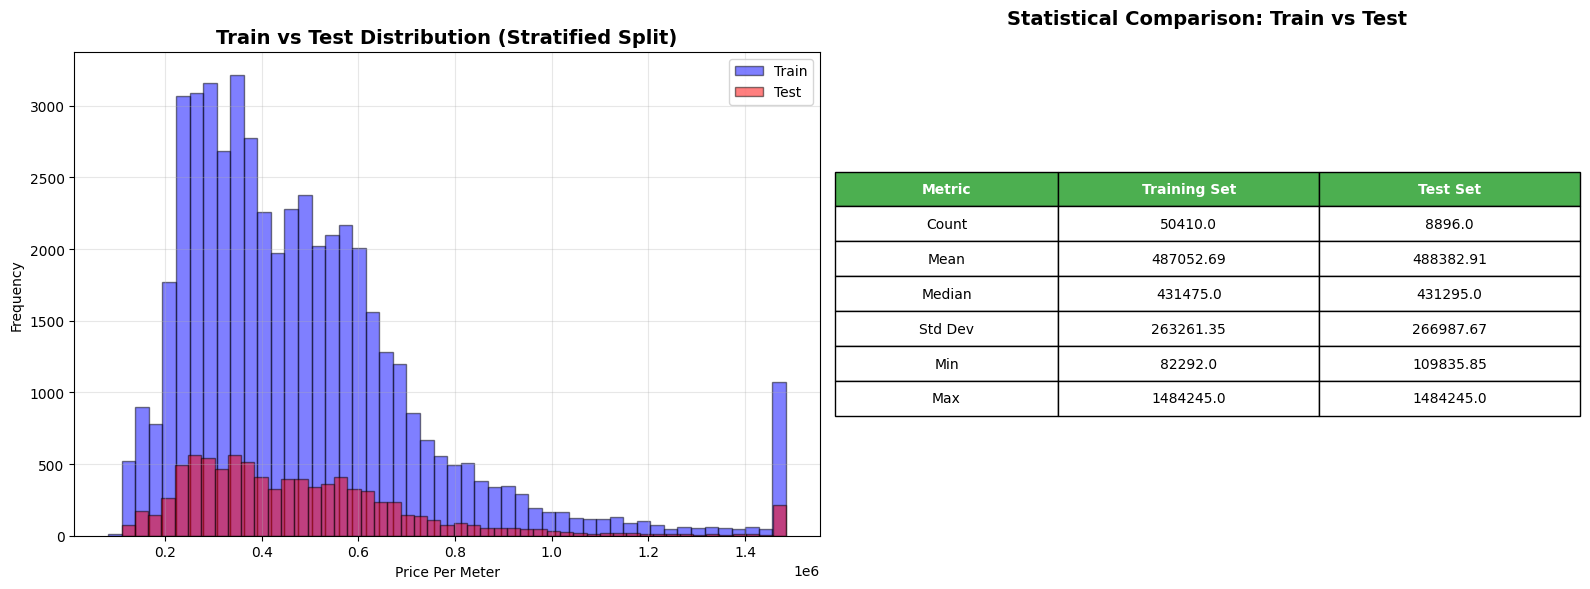

In [29]:
# Visualization 5: Train-Test Split Distribution
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Histogram comparison
axes[0].hist(y_train, bins=50, alpha=0.5, label='Train', color='blue', edgecolor='black')
axes[0].hist(y_test, bins=50, alpha=0.5, label='Test', color='red', edgecolor='black')
axes[0].set_xlabel('Price Per Meter')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Train vs Test Distribution (Stratified Split)', fontsize=14, fontweight='bold')
axes[0].legend()
axes[0].grid(alpha=0.3)

# Statistical comparison
stats_comparison = pd.DataFrame({
    'Metric': ['Count', 'Mean', 'Median', 'Std Dev', 'Min', 'Max'],
    'Training Set': [
        len(y_train),
        y_train.mean(),
        y_train.median(),
        y_train.std(),
        y_train.min(),
        y_train.max()
    ],
    'Test Set': [
        len(y_test),
        y_test.mean(),
        y_test.median(),
        y_test.std(),
        y_test.min(),
        y_test.max()
    ]
})

axes[1].axis('off')
table = axes[1].table(cellText=stats_comparison.round(2).values,
                      colLabels=stats_comparison.columns,
                      cellLoc='center',
                      loc='center',
                      colWidths=[0.3, 0.35, 0.35])
table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1, 2)

# Color header
for i in range(len(stats_comparison.columns)):
    table[(0, i)].set_facecolor('#4CAF50')
    table[(0, i)].set_text_props(weight='bold', color='white')

axes[1].set_title('Statistical Comparison: Train vs Test', fontsize=14, fontweight='bold', pad=20)

plt.tight_layout()

plt.show()

## 6. Target Encoding with Smoothing (Leakage-Free)

**What is Target Encoding?**
- Converts categorical variables into numeric by using the target variable
- Instead of "District = Центральный", we get "District_Price_Mean = 285000"
- Captures the relationship between category and price directly

**The Smoothing Formula:**
```
encoded_value = (count × category_mean + smoothing × global_mean) / (count + smoothing)
```

**Why Smoothing?**
Consider two districts:
- District A: 1000 properties, mean price = 200,000
- District B: 2 properties, mean price = 500,000

Without smoothing: District B looks amazing (500k!)
With smoothing (α=10): District B's mean gets pulled toward global mean
→ We trust statistics from larger samples more

**Example Calculation:**
District with 5 properties averaging 300,000, global mean = 250,000, smoothing = 10:
encoded = (5 × 300,000 + 10 × 250,000) / (5 + 10)
        = (1,500,000 + 2,500,000) / 15
        = 266,667

**Features Created for Each Category:**
1. **Mean**: Smoothed average price in that category
2. **Median**: Middle value (robust to outliers)
3. **Std**: Price variation (high std = risky/mixed area)
4. **Count**: Number of properties (confidence measure)

**Why This Prevents Leakage:**
- Statistics calculated ONLY from training data
- Test data encoded using training statistics
- Model never sees test set during training

In [30]:
def target_encode_column(train_cat, train_target, test_cat, col_name, smoothing=10):
    """
    Target encode a categorical column without leakage.
    Uses only training data statistics.

    Smoothing formula:
    encoded_value = (count * mean + smoothing * global_mean) / (count + smoothing)
    """
    # Calculate statistics from training data only
    stats = pd.DataFrame({
        col_name: train_cat,
        'target': train_target
    }).groupby(col_name)['target'].agg(['mean', 'median', 'std', 'count']).reset_index()

    # Global mean from training data
    global_mean = train_target.mean()
    global_median = train_target.median()

    # Apply smoothing to handle rare categories
    stats['mean_smooth'] = (stats['count'] * stats['mean'] + smoothing * global_mean) / (stats['count'] + smoothing)
    stats['median_smooth'] = (stats['count'] * stats['median'] + smoothing * global_median) / (stats['count'] + smoothing)

    # Fill NaN in std with 0
    stats['std'] = stats['std'].fillna(0)

    # Create mapping dictionaries
    mean_map = dict(zip(stats[col_name], stats['mean_smooth']))
    median_map = dict(zip(stats[col_name], stats['median_smooth']))
    std_map = dict(zip(stats[col_name], stats['std']))
    count_map = dict(zip(stats[col_name], stats['count']))

    # Encode train set
    train_mean = train_cat.map(mean_map).fillna(global_mean)
    train_median = train_cat.map(median_map).fillna(global_median)
    train_std = train_cat.map(std_map).fillna(0)
    train_count = train_cat.map(count_map).fillna(0)

    # Encode test set (using training statistics)
    test_mean = test_cat.map(mean_map).fillna(global_mean)
    test_median = test_cat.map(median_map).fillna(global_median)
    test_std = test_cat.map(std_map).fillna(0)
    test_count = test_cat.map(count_map).fillna(0)

    return {
        'train_mean': train_mean,
        'train_median': train_median,
        'train_std': train_std,
        'train_count': train_count,
        'test_mean': test_mean,
        'test_median': test_median,
        'test_std': test_std,
        'test_count': test_count
    }


In [31]:
# Apply to each categorical
target_encoded_features = {}

for col in categorical_features:
    print(f"  Encoding: {col}")
    encoded = target_encode_column(
        cat_train[col].reset_index(drop=True),
        y_train.reset_index(drop=True),
        cat_test[col].reset_index(drop=True),
        col,
        smoothing=10
    )
    target_encoded_features[col] = encoded

# Add target-encoded features to X_train and X_test
for col in categorical_features:
    X_train[f'{col}_Price_Mean'] = target_encoded_features[col]['train_mean'].values
    X_train[f'{col}_Price_Median'] = target_encoded_features[col]['train_median'].values
    X_train[f'{col}_Price_Std'] = target_encoded_features[col]['train_std'].values
    X_train[f'{col}_Price_Count'] = target_encoded_features[col]['train_count'].values

    X_test[f'{col}_Price_Mean'] = target_encoded_features[col]['test_mean'].values
    X_test[f'{col}_Price_Median'] = target_encoded_features[col]['test_median'].values
    X_test[f'{col}_Price_Std'] = target_encoded_features[col]['test_std'].values
    X_test[f'{col}_Price_Count'] = target_encoded_features[col]['test_count'].values

print(f"Final feature count: {X_train.shape[1]}")

  Encoding: District
  Encoding: Class
  Encoding: Developer_encoded
  Encoding: Complex_encoded
Final feature count: 68


## Step 6: Model Training - Gradient Boosting Regressor

**Why Gradient Boosting?**
- Builds trees sequentially, each correcting previous errors
- Excellent for tabular data with mixed feature types
- Handles non-linear relationships and interactions naturally
- Robust to outliers and missing values

**Hyperparameters Explained:**

**n_estimators = 2000**
- Number of trees to build sequentially
- More trees = better learning but slower training
- We use early stopping to prevent overfitting

**learning_rate = 0.02**
- How much each tree contributes to final prediction
- Lower = more conservative, needs more trees
- Higher = faster learning but risk of overfitting
- 0.02 is conservative, ensures stable learning

**max_depth = 7**
- Maximum tree depth (levels of splits)
- Controls model complexity
- 7 allows capturing complex patterns without extreme overfitting

**min_samples_split = 20 & min_samples_leaf = 10**
- Minimum samples required to split a node / be in a leaf
- Prevents overfitting to noise
- Forces trees to find robust patterns

**subsample = 0.8**
- Use 80% of data for each tree (random sampling)
- Introduces randomness → better generalization
- Similar to "bagging" in Random Forests

**max_features = 'sqrt'**
- Consider √(n_features) random features per split
- Further reduces overfitting through randomness
- Helps with feature diversity across trees

**n_iter_no_change = 100**
- Stop if validation score doesn't improve for 100 iterations
- Automatic early stopping prevents wasted computation
- Uses 10% of training data as validation set

**Why These Settings?**
- Conservative learning rate + many trees = stable learning
- Depth 7 + min_samples controls = complex but not overfitted
- Subsampling + max_features = ensemble diversity
- Result: Robust model that generalizes well

In [32]:
model = GradientBoostingRegressor(
    n_estimators=2000,
    learning_rate=0.02,
    max_depth=7,
    min_samples_split=20,
    min_samples_leaf=10,
    subsample=0.8,
    max_features='sqrt',
    loss='squared_error',
    random_state=42,
    validation_fraction=0.1,
    n_iter_no_change=100,
    verbose=1
)

model.fit(X_train, y_train)

print(f"\nModel trained successfully!")
print(f"Trees built: {model.n_estimators_}")
print(f"Best iteration: {model.n_estimators_}")

      Iter       Train Loss      OOB Improve   Remaining Time 
         1 67707387177.0873  2459474498.1318            2.98m
         2 65676267745.6379  3798978255.4501            3.32m
         3 62603679385.9300  -250889235.5792            3.12m
         4 59886281029.8117   707372129.8006            3.12m
         5 57657682725.9780  1941339555.6712            3.10m
         6 55727166248.7245  2719146913.8677            3.11m
         7 54113855455.1707  3841963844.2013            3.08m
         8 51977029158.5795  1327193056.9357            3.06m
         9 49857693828.3276   726924341.7056            3.07m
        10 48268963685.7235  2704027912.6789            3.04m
        20 33371234436.5107  -161752550.9026            3.00m
        30 23724497289.9161  2191600133.7267            2.98m
        40 16899719033.1282   956373897.7373            3.04m
        50 12282910284.5220   679144338.3690            3.24m
        60  9017886715.1288    97141204.6899            3.32m
       

## Step 7: Model Evaluation

**Metrics Used:**

**1. RMSE (Root Mean Squared Error)**
- Average prediction error in same units as target (rubles/m²)
- Penalizes large errors more heavily (squared term)
- Lower is better
- Example: RMSE = 15,000 means typical error is ±15,000 rubles/m²

**2. MAE (Mean Absolute Error)**
- Average absolute error (more intuitive than RMSE)
- Less sensitive to outliers than RMSE
- Example: MAE = 10,000 means average error is 10,000 rubles/m²

**3. R² Score (Coefficient of Determination)**
- Proportion of variance explained by model (0 to 1)
- R² = 1: Perfect predictions
- R² = 0: Model no better than predicting mean
- Example: R² = 0.85 means model explains 85% of price variation

**Overfitting Analysis:**
- Compare train vs test metrics
- Small gap = good generalization
- Large gap = overfitting (memorizing training data)
- We aim for <10% gap in RMSE

In [33]:
# Get predictions
train_preds = model.predict(X_train)
test_preds = model.predict(X_test)

# Calculate metrics
train_rmse = np.sqrt(mean_squared_error(y_train, train_preds))
test_rmse = np.sqrt(mean_squared_error(y_test, test_preds))
train_mae = mean_absolute_error(y_train, train_preds)
test_mae = mean_absolute_error(y_test, test_preds)
train_r2 = r2_score(y_train, train_preds)
test_r2 = r2_score(y_test, test_preds)

print(f"\n TRAINING SET METRICS:")
print(f"RMSE: {train_rmse:,.2f} rubles/m²")
print(f"MAE:  {train_mae:,.2f} rubles/m²")
print(f"R²:   {train_r2:.4f} ({train_r2*100:.2f}% variance explained)")

print(f"\n TEST SET METRICS:")
print(f"RMSE: {test_rmse:,.2f} rubles/m²")
print(f"MAE:  {test_mae:,.2f} rubles/m²")
print(f"R²:   {test_r2:.4f} ({test_r2*100:.2f}% variance explained)")

# Overfitting analysis
overfitting_gap = test_rmse - train_rmse
overfitting_pct = (overfitting_gap / test_rmse) * 100

print(f"\n OVERFITTING ANALYSIS:")
print(f"Train-Test RMSE Gap: {overfitting_gap:,.2f}")
print(f"Gap as % of Test RMSE: {overfitting_pct:.2f}%")

if overfitting_pct < 10:
    status = "Excellent - Minimal overfitting"
    color = "green"
elif overfitting_pct < 20:
    status = "Good - Moderate overfitting"
    color = "orange"
else:
    status = " Warning - Severe overfitting"
    color = "red"
print(f"  Status: {status}")

# Error analysis
errors = y_test - test_preds
abs_errors = np.abs(errors)
pct_errors = (abs_errors / y_test) * 100

within_5pct = (pct_errors <= 5).sum() / len(pct_errors) * 100
within_10pct = (pct_errors <= 10).sum() / len(pct_errors) * 100
within_15pct = (pct_errors <= 15).sum() / len(pct_errors) * 100
within_20pct = (pct_errors <= 20).sum() / len(pct_errors) * 100

print(f"\n PREDICTION ACCURACY:")
print(f"Within 5% of actual:  {within_5pct:.1f}%")
print(f"Within 10% of actual: {within_10pct:.1f}%")
print(f"Within 15% of actual: {within_15pct:.1f}%")
print(f"Within 20% of actual: {within_20pct:.1f}%")



 TRAINING SET METRICS:
  RMSE: 21,691.66 rubles/m²
  MAE:  12,867.72 rubles/m²
  R²:   0.9932 (99.32% variance explained)

 TEST SET METRICS:
  RMSE: 28,005.10 rubles/m²
  MAE:  15,655.36 rubles/m²
  R²:   0.9890 (98.90% variance explained)

 OVERFITTING ANALYSIS:
  Train-Test RMSE Gap: 6,313.44
  Gap as % of Test RMSE: 22.54%
  Status:  Warning - Severe overfitting

 PREDICTION ACCURACY:
  Within 5% of actual:  81.0%
  Within 10% of actual: 95.6%
  Within 15% of actual: 98.4%
  Within 20% of actual: 99.2%


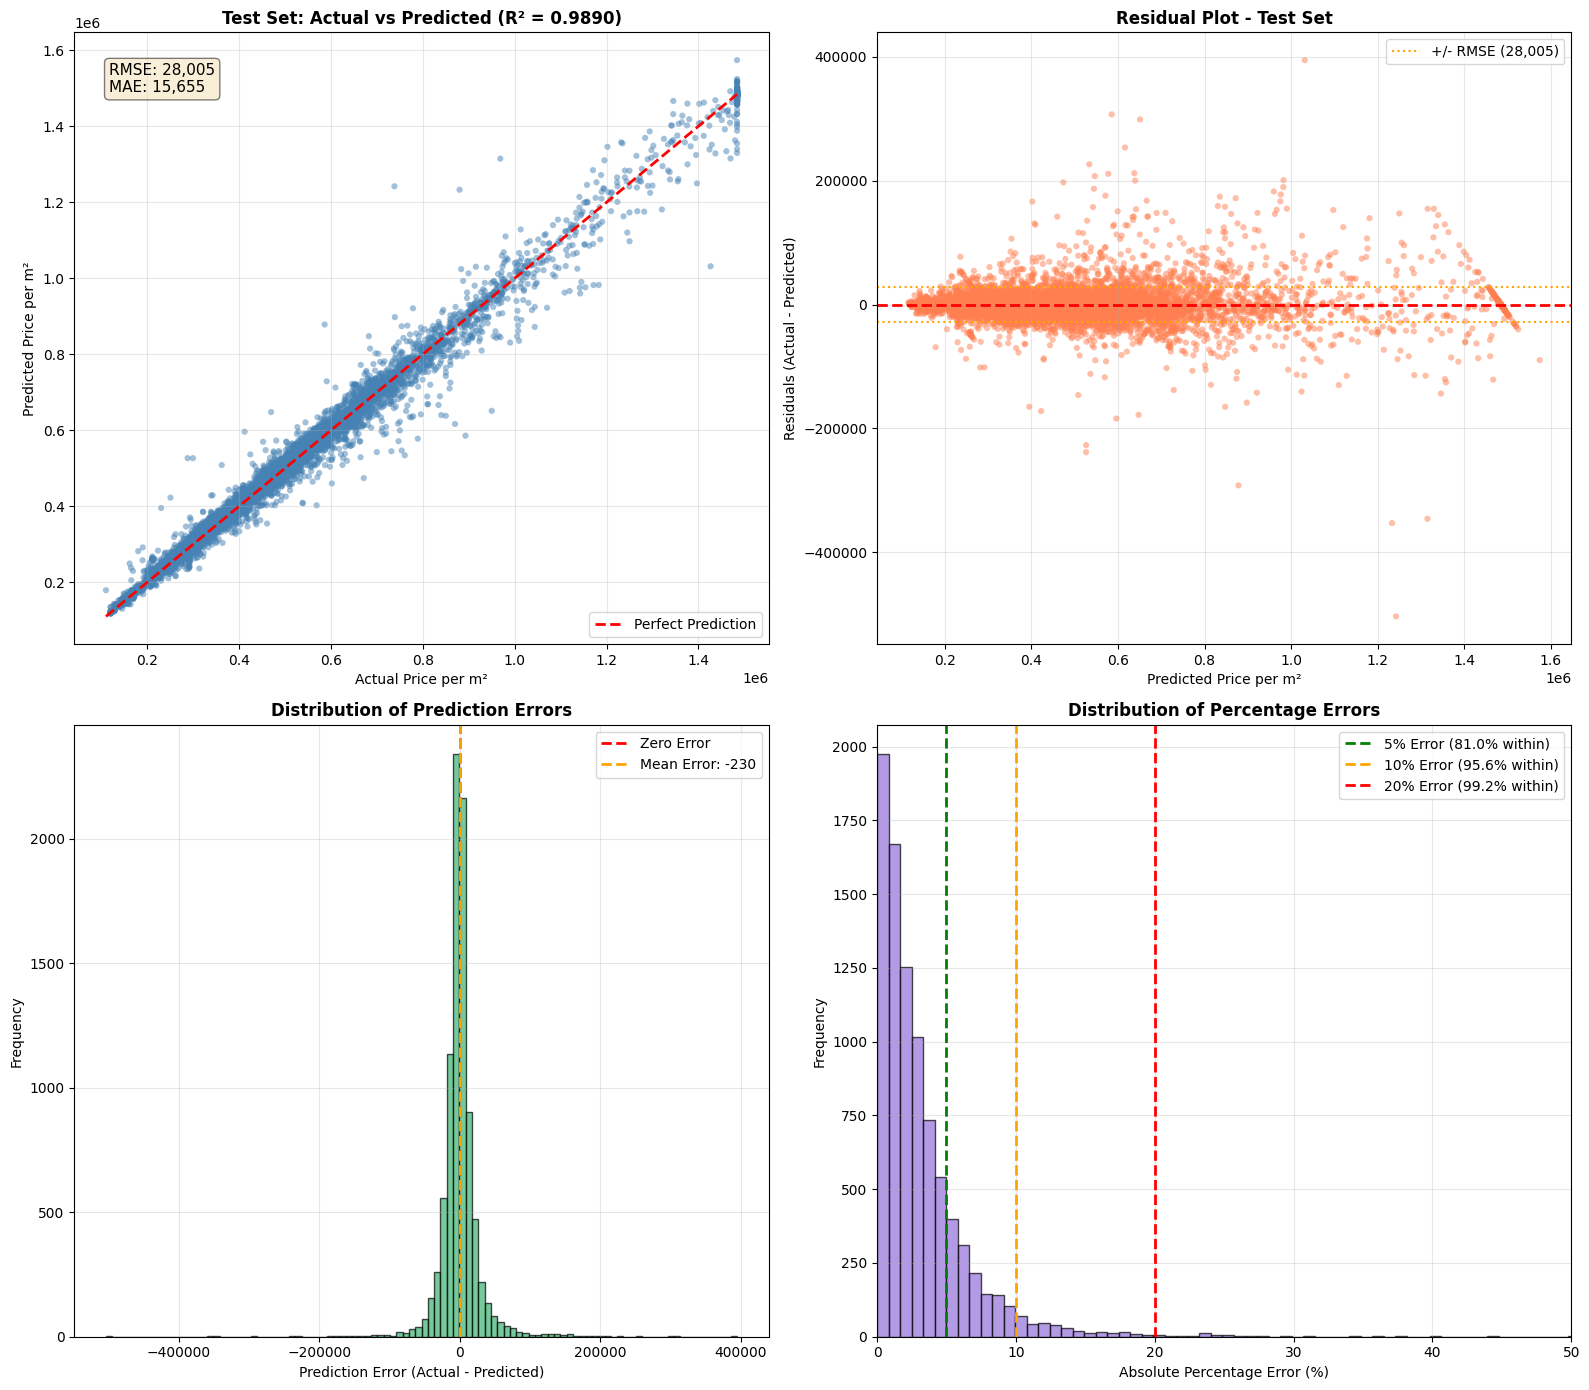

In [34]:
# Visualization 7: Actual vs Predicted
fig, axes = plt.subplots(2, 2, figsize=(16, 14))

# Scatter plot - Test set
axes[0, 0].scatter(y_test, test_preds, alpha=0.5, s=20, color='steelblue', edgecolors='none')
axes[0, 0].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()],
                'r--', lw=2, label='Perfect Prediction')
axes[0, 0].set_xlabel('Actual Price per m²')
axes[0, 0].set_ylabel('Predicted Price per m²')
axes[0, 0].set_title(f'Test Set: Actual vs Predicted (R² = {test_r2:.4f})', fontweight='bold')
axes[0, 0].legend()
axes[0, 0].grid(alpha=0.3)

# Add R² annotation
axes[0, 0].text(0.05, 0.95, f'RMSE: {test_rmse:,.0f}\nMAE: {test_mae:,.0f}',
                transform=axes[0, 0].transAxes, fontsize=11,
                verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

# Residuals plot
axes[0, 1].scatter(test_preds, errors, alpha=0.5, s=20, color='coral', edgecolors='none')
axes[0, 1].axhline(y=0, color='red', linestyle='--', lw=2)
axes[0, 1].axhline(y=test_rmse, color='orange', linestyle=':', lw=1.5, label=f'+/- RMSE ({test_rmse:,.0f})')
axes[0, 1].axhline(y=-test_rmse, color='orange', linestyle=':', lw=1.5)
axes[0, 1].set_xlabel('Predicted Price per m²')
axes[0, 1].set_ylabel('Residuals (Actual - Predicted)')
axes[0, 1].set_title('Residual Plot - Test Set', fontweight='bold')
axes[0, 1].legend()
axes[0, 1].grid(alpha=0.3)

# Error distribution
axes[1, 0].hist(errors, bins=100, edgecolor='black', alpha=0.7, color='mediumseagreen')
axes[1, 0].axvline(0, color='red', linestyle='--', lw=2, label='Zero Error')
axes[1, 0].axvline(errors.mean(), color='orange', linestyle='--', lw=2, label=f'Mean Error: {errors.mean():.0f}')
axes[1, 0].set_xlabel('Prediction Error (Actual - Predicted)')
axes[1, 0].set_ylabel('Frequency')
axes[1, 0].set_title('Distribution of Prediction Errors', fontweight='bold')
axes[1, 0].legend()
axes[1, 0].grid(alpha=0.3)

# Percentage error distribution
axes[1, 1].hist(pct_errors, bins=100, edgecolor='black', alpha=0.7, color='mediumpurple')
axes[1, 1].axvline(5, color='green', linestyle='--', lw=2, label=f'5% Error ({within_5pct:.1f}% within)')
axes[1, 1].axvline(10, color='orange', linestyle='--', lw=2, label=f'10% Error ({within_10pct:.1f}% within)')
axes[1, 1].axvline(20, color='red', linestyle='--', lw=2, label=f'20% Error ({within_20pct:.1f}% within)')
axes[1, 1].set_xlabel('Absolute Percentage Error (%)')
axes[1, 1].set_ylabel('Frequency')
axes[1, 1].set_title('Distribution of Percentage Errors', fontweight='bold')
axes[1, 1].legend()
axes[1, 1].grid(alpha=0.3)
axes[1, 1].set_xlim(0, min(50, pct_errors.max()))

plt.tight_layout()

plt.show()


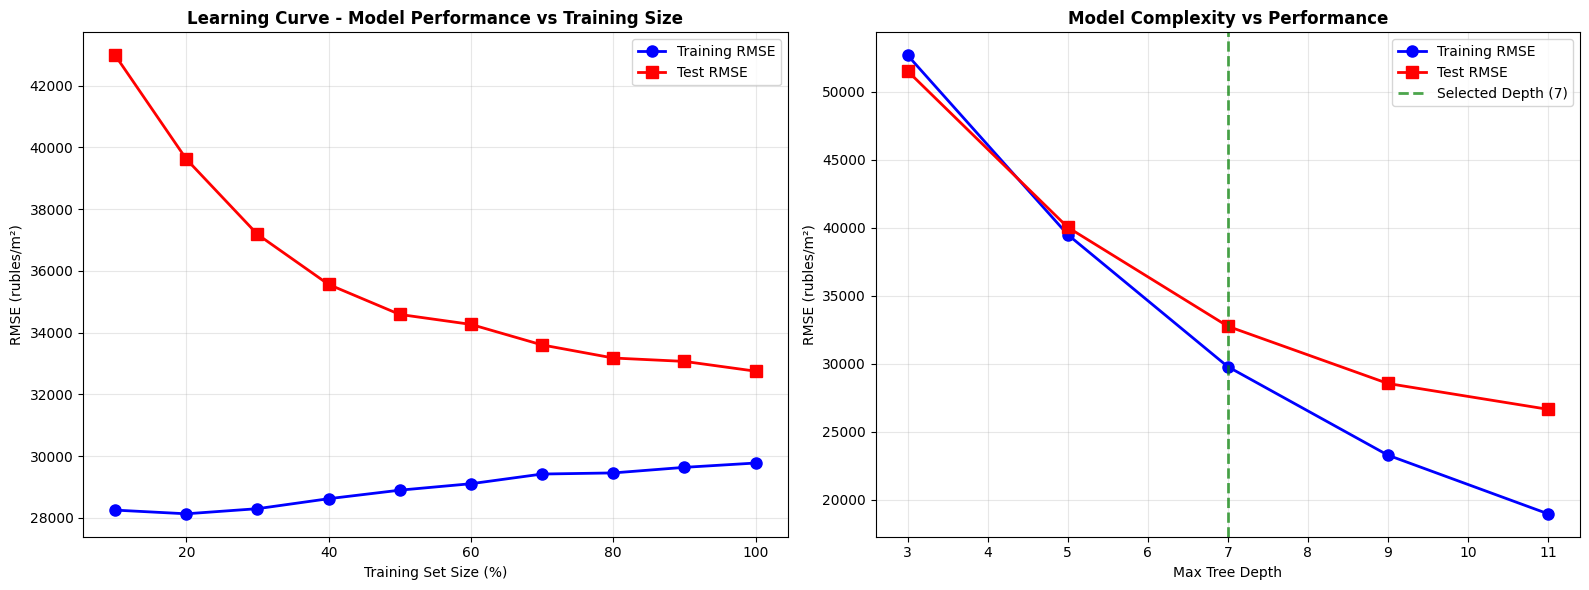

In [35]:
# Visualization 8: Learning Curves
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Train vs Test performance
train_sizes = np.linspace(0.1, 1.0, 10)
train_rmses = []
test_rmses = []

for size in train_sizes:
    if size < 1.0:
        X_subset, _, y_subset, _ = train_test_split(X_train, y_train, train_size=size, random_state=42)
    else:
        X_subset, y_subset = X_train, y_train

    temp_model = GradientBoostingRegressor(
        n_estimators=500, learning_rate=0.02, max_depth=7,
        min_samples_split=20, min_samples_leaf=10, subsample=0.8,
        max_features='sqrt', random_state=42, verbose=0
    )
    temp_model.fit(X_subset, y_subset)

    train_pred = temp_model.predict(X_subset)
    test_pred = temp_model.predict(X_test)

    train_rmses.append(np.sqrt(mean_squared_error(y_subset, train_pred)))
    test_rmses.append(np.sqrt(mean_squared_error(y_test, test_pred)))

axes[0].plot(train_sizes * 100, train_rmses, 'o-', label='Training RMSE', color='blue', linewidth=2, markersize=8)
axes[0].plot(train_sizes * 100, test_rmses, 's-', label='Test RMSE', color='red', linewidth=2, markersize=8)
axes[0].set_xlabel('Training Set Size (%)')
axes[0].set_ylabel('RMSE (rubles/m²)')
axes[0].set_title('Learning Curve - Model Performance vs Training Size', fontweight='bold')
axes[0].legend()
axes[0].grid(alpha=0.3)
# Model complexity vs performance
max_depths = [3, 5, 7, 9, 11]
complexity_train_rmse = []
complexity_test_rmse = []

for depth in max_depths:
    temp_model = GradientBoostingRegressor(
        n_estimators=500, learning_rate=0.02, max_depth=depth,
        min_samples_split=20, min_samples_leaf=10, subsample=0.8,
        max_features='sqrt', random_state=42, verbose=0
    )
    temp_model.fit(X_train, y_train)

    train_pred = temp_model.predict(X_train)
    test_pred = temp_model.predict(X_test)

    complexity_train_rmse.append(np.sqrt(mean_squared_error(y_train, train_pred)))
    complexity_test_rmse.append(np.sqrt(mean_squared_error(y_test, test_pred)))

axes[1].plot(max_depths, complexity_train_rmse, 'o-', label='Training RMSE', color='blue', linewidth=2, markersize=8)
axes[1].plot(max_depths, complexity_test_rmse, 's-', label='Test RMSE', color='red', linewidth=2, markersize=8)
axes[1].axvline(7, color='green', linestyle='--', linewidth=2, alpha=0.7, label='Selected Depth (7)')
axes[1].set_xlabel('Max Tree Depth')
axes[1].set_ylabel('RMSE (rubles/m²)')
axes[1].set_title('Model Complexity vs Performance', fontweight='bold')
axes[1].legend()
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

## 9. Feature Importance Analysis

**What is Feature Importance?**
- Measures how much each feature contributes to predictions
- Based on how often and how effectively feature is used in tree splits
- Higher importance = more influential in determining price

**Interpretation:**
- Features at the top are the primary price drivers
- Target-encoded features (District_Price_Mean, etc.) often rank high
  because they capture location-specific price patterns
- Physical features (TotalArea, Floor, etc.) capture property characteristics
- Interaction features (Rooms_x_Area, etc.) capture combined effects

**Why This Matters:**
- Identifies what buyers/sellers should focus on
- Validates our feature engineering choices
- Helps explain predictions to stakeholders
- Can guide further feature development

FEATURE IMPORTANCE ANALYSIS

TOP 20 MOST IMPORTANT FEATURES:
------------------------------------------------------------
Complex_encoded_Price_Median         0.1896
Complex_encoded_Price_Mean           0.1547
District_Price_Median                0.1144
District_Price_Mean                  0.0762
Developer_encoded_Price_Mean         0.0654
Class_Price_Median                   0.0527
Developer_encoded_Price_Median       0.0473
District_Price_Std                   0.0353
Class_encoded                        0.0260
Is_Oblast                            0.0253
Complex_encoded_Price_Std            0.0239
Class_Price_Mean                     0.0231
Class_Price_Std                      0.0119
TotalArea_Squared                    0.0113
FloorsTotal                          0.0109
Quality_x_Area                       0.0091
TotalArea_Log                        0.0089
Developer_encoded_Price_Std          0.0085
TotalArea                            0.0085
Rooms_x_Area                         0.008

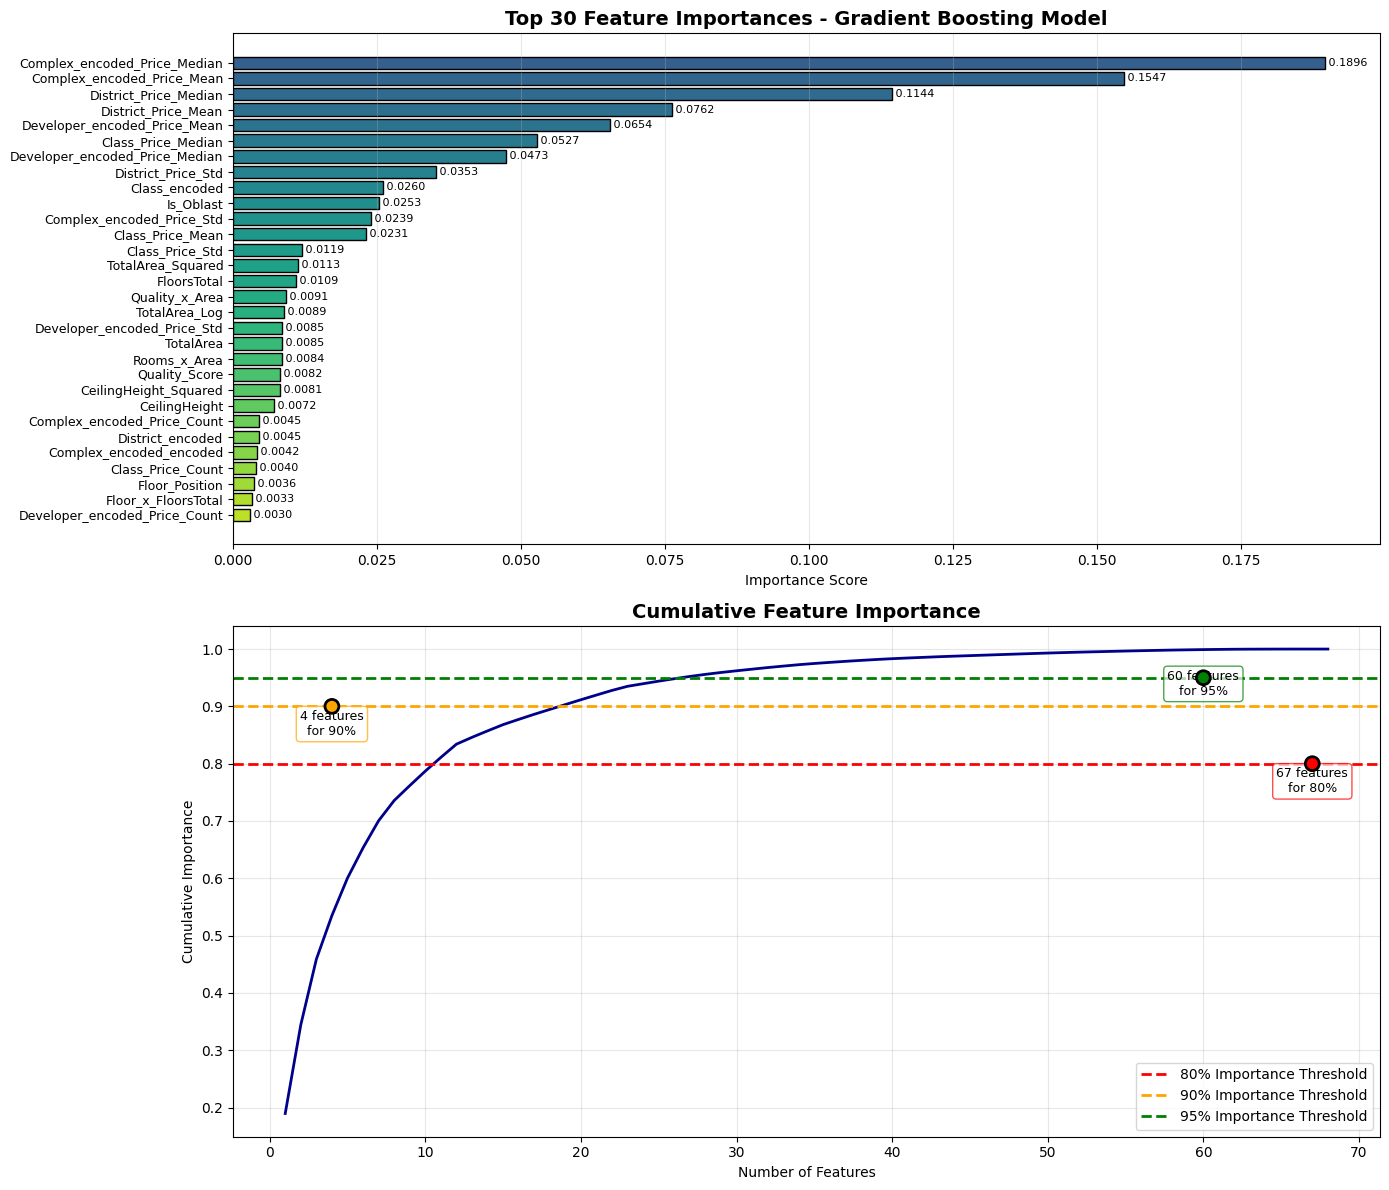


Feature Selection Insights:
  67 features explain 80% of model's predictive power
  4 features explain 90% of model's predictive power
  60 features explain 95% of model's predictive power

Feature Importance by Category:
  Target Encoded: 0.8172 (16 features)
  Polynomial/Interactions: 0.0510 (7 features)
  Ratios: 0.0052 (6 features)
  Binary Flags: 0.0302 (9 features)
  Other: 0.0964 (30 features)


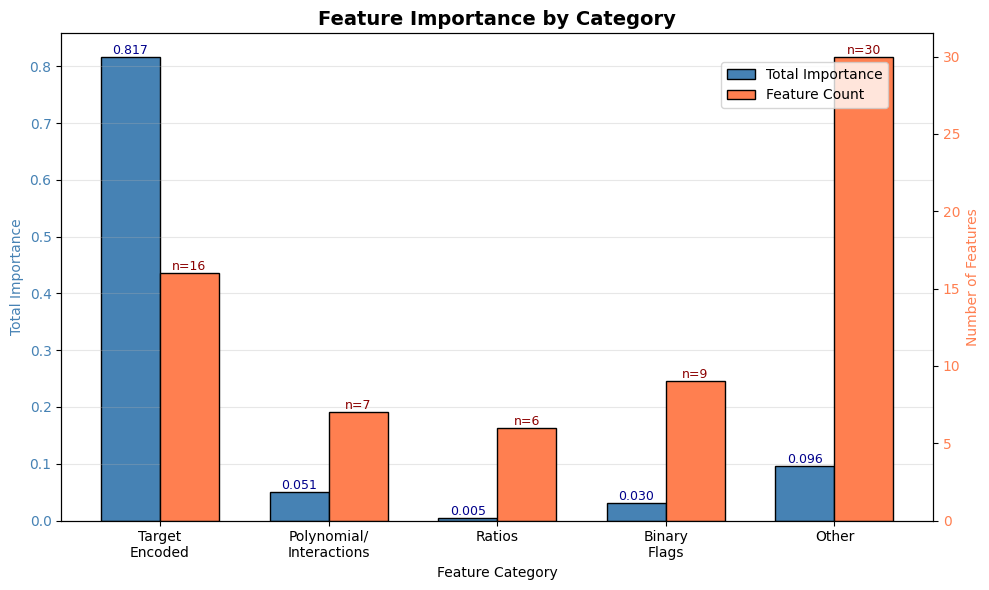

In [36]:

print("FEATURE IMPORTANCE ANALYSIS")


# Get feature importance
feature_importance = pd.DataFrame({
    'feature': X_train.columns,
    'importance': model.feature_importances_
}).sort_values('importance', ascending=False)

# Top 20 features
top_20_features = feature_importance.head(20)

print("\nTOP 20 MOST IMPORTANT FEATURES:")
print("-" * 60)
for idx, row in top_20_features.iterrows():
    bar_length = int(row['importance'] * 100)
    bar = '' * bar_length
    print(f"{row['feature']:35s} {bar} {row['importance']:.4f}")

# Visualization 9: Feature Importance
fig, axes = plt.subplots(2, 1, figsize=(14, 12))

# Top 30 features bar chart
top_30 = feature_importance.head(30)
colors_importance = plt.cm.viridis(np.linspace(0.3, 0.9, len(top_30)))

axes[0].barh(range(len(top_30)), top_30['importance'], color=colors_importance, edgecolor='black')
axes[0].set_yticks(range(len(top_30)))
axes[0].set_yticklabels(top_30['feature'], fontsize=9)
axes[0].set_xlabel('Importance Score')
axes[0].set_title('Top 30 Feature Importances - Gradient Boosting Model', fontsize=14, fontweight='bold')
axes[0].grid(alpha=0.3, axis='x')
axes[0].invert_yaxis()

# Add value labels
for i, (feat, imp) in enumerate(zip(top_30['feature'], top_30['importance'])):
    axes[0].text(imp, i, f' {imp:.4f}', va='center', fontsize=8)

# Cumulative importance
feature_importance_sorted = feature_importance.sort_values('importance', ascending=False)
cumsum = feature_importance_sorted['importance'].cumsum()

axes[1].plot(range(1, len(cumsum) + 1), cumsum, linewidth=2, color='darkblue')
axes[1].axhline(y=0.8, color='red', linestyle='--', linewidth=2, label='80% Importance Threshold')
axes[1].axhline(y=0.9, color='orange', linestyle='--', linewidth=2, label='90% Importance Threshold')
axes[1].axhline(y=0.95, color='green', linestyle='--', linewidth=2, label='95% Importance Threshold')

# Find where we cross thresholds
n_80 = (cumsum >= 0.8).idxmax() + 1 if (cumsum >= 0.8).any() else len(cumsum)
n_90 = (cumsum >= 0.9).idxmax() + 1 if (cumsum >= 0.9).any() else len(cumsum)
n_95 = (cumsum >= 0.95).idxmax() + 1 if (cumsum >= 0.95).any() else len(cumsum)

axes[1].scatter([n_80, n_90, n_95], [0.8, 0.9, 0.95], color=['red', 'orange', 'green'],
                s=100, zorder=5, edgecolors='black', linewidth=2)

axes[1].set_xlabel('Number of Features')
axes[1].set_ylabel('Cumulative Importance')
axes[1].set_title('Cumulative Feature Importance', fontsize=14, fontweight='bold')
axes[1].legend()
axes[1].grid(alpha=0.3)

# Add annotations
axes[1].text(n_80, 0.75, f'{n_80} features\nfor 80%', ha='center', fontsize=9,
             bbox=dict(boxstyle='round', facecolor='white', edgecolor='red', alpha=0.7))
axes[1].text(n_90, 0.85, f'{n_90} features\nfor 90%', ha='center', fontsize=9,
             bbox=dict(boxstyle='round', facecolor='white', edgecolor='orange', alpha=0.7))
axes[1].text(n_95, 0.92, f'{n_95} features\nfor 95%', ha='center', fontsize=9,
             bbox=dict(boxstyle='round', facecolor='white', edgecolor='green', alpha=0.7))

plt.tight_layout()
plt.show()


print(f"\nFeature Selection Insights:")
print(f"  {n_80} features explain 80% of model's predictive power")
print(f"  {n_90} features explain 90% of model's predictive power")
print(f"  {n_95} features explain 95% of model's predictive power")

# Categorize features by type
target_encoded = feature_importance[feature_importance['feature'].str.contains('_Price_')]
polynomial = feature_importance[feature_importance['feature'].str.contains('Squared|Log|_x_')]
ratio = feature_importance[feature_importance['feature'].str.contains('_to_|Efficiency|_Per_')]
binary = feature_importance[feature_importance['feature'].str.contains('Is_|Has_')]
other = feature_importance[~feature_importance['feature'].isin(
    pd.concat([target_encoded, polynomial, ratio, binary])['feature']
)]

print(f"\nFeature Importance by Category:")
print(f"  Target Encoded: {target_encoded['importance'].sum():.4f} ({len(target_encoded)} features)")
print(f"  Polynomial/Interactions: {polynomial['importance'].sum():.4f} ({len(polynomial)} features)")
print(f"  Ratios: {ratio['importance'].sum():.4f} ({len(ratio)} features)")
print(f"  Binary Flags: {binary['importance'].sum():.4f} ({len(binary)} features)")
print(f"  Other: {other['importance'].sum():.4f} ({len(other)} features)")

# Visualization 10: Feature Categories
fig, ax = plt.subplots(figsize=(10, 6))

categories = ['Target\nEncoded', 'Polynomial/\nInteractions', 'Ratios', 'Binary\nFlags', 'Other']
importances = [
    target_encoded['importance'].sum(),
    polynomial['importance'].sum(),
    ratio['importance'].sum(),
    binary['importance'].sum(),
    other['importance'].sum()
]
counts = [len(target_encoded), len(polynomial), len(ratio), len(binary), len(other)]

x = np.arange(len(categories))
width = 0.35

bars1 = ax.bar(x - width/2, importances, width, label='Total Importance', color='steelblue', edgecolor='black')
ax2 = ax.twinx()
bars2 = ax2.bar(x + width/2, counts, width, label='Feature Count', color='coral', edgecolor='black')

ax.set_xlabel('Feature Category')
ax.set_ylabel('Total Importance', color='steelblue')
ax2.set_ylabel('Number of Features', color='coral')
ax.set_title('Feature Importance by Category', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(categories)
ax.tick_params(axis='y', labelcolor='steelblue')
ax2.tick_params(axis='y', labelcolor='coral')

# Add value labels
for bar, val in zip(bars1, importances):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'{val:.3f}', ha='center', va='bottom', fontsize=9, color='darkblue')

for bar, val in zip(bars2, counts):
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height,
             f'n={val}', ha='center', va='bottom', fontsize=9, color='darkred')

ax.grid(alpha=0.3, axis='y')
fig.legend(loc='upper right', bbox_to_anchor=(0.9, 0.9))
plt.tight_layout()
plt.show()

In [37]:
import joblib

# Ensure the keys here match exactly what the Streamlit app expects
model_bundle = {
    'model': model,
    'feature_names': X_train.columns.tolist(),
    'target_maps': target_encoded_features, # <--- THIS MUST MATCH
    'medians': X_train.select_dtypes(include=[np.number]).median().to_dict(),
    'global_mean': y_train.mean(),
    'global_median': y_train.median()
}

# Save the file
joblib.dump(model_bundle, 'real_estate_model_bundle.pkl', compress=3)
print("Bundle saved with key 'target_maps'")

Bundle saved with key 'target_maps'
